In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

The code block below defines a few helper functions to visualize the results. You do not need to touch them.

In [2]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue).

In [3]:

# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


(<Figure size 1000x1000 with 100 Axes>, <Axes: >)

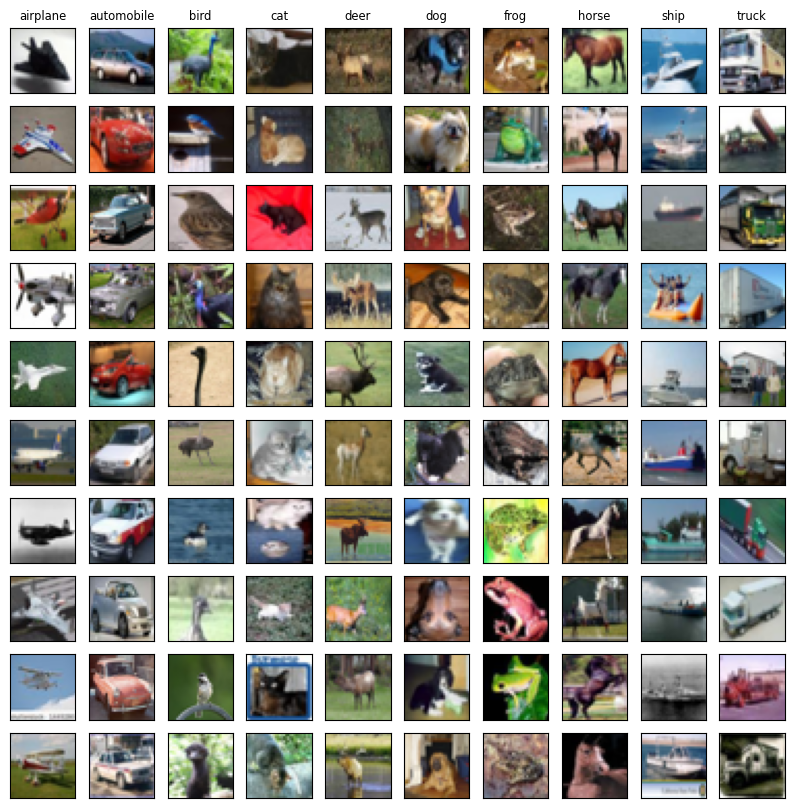

In [4]:
# Hint: To plot example images, you can use the plot examples function
plot_examples(x_train, y_train)

In [5]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# Hint: normalize the data
# Normalize
x_train = x_train / 255
x_test = x_test / 255

# Hint: use 20% of the training data for validation
x_valid = x_test[8000:]
x_test = x_test[:8000]

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")
print("\ny_train shape:", y_train.shape)
print(y_train_onehot.shape[0], "train samples")
print(y_valid_onehot.shape[0], "validation samples")
print(y_test_onehot.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
2000 validation samples
8000 test samples

y_train shape: (50000, 1)
50000 train samples
2000 validation samples
8000 test samples


We start with a fully connected network

In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    ...
)

model.fit(
    ...
    batch_size=...,
    epochs=20, # train at least for 20 epochs
    verbose=2,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

In [ ]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)


# Hint: this is how you can plot the confusion matrix.
# calculate predictions for test set
y_predict = model.predict(..., batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

In [ ]:
# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

**CNN**
In the second part of this exercise, classify the images with a CNN.


In [ ]:
# Hint: this code snipped shows how to define convolution and maxpooling layers. For more information see
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        ... # add additional convolution layer and max pooling layer here,
        layers.Flatten(),
        ... # add dropout and output layer
    ],
    name="cnn",
)

print(model.summary())

In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
...
)

model.fit(
    ...
    batch_size=..,
    epochs=40,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

In [6]:
x_train.shape

(50000, 32, 32, 3)

In [17]:
x_train[0][0]

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93],
       [131, 103,  77],
       [125,  99,  76],
       [142, 115,  91],
       [144, 112,  86],
       [137, 105,  79],
       [129,  97,  71],
       [137, 106,  79],
       [134, 106,  76],
       [124,  97,  64],
       [139, 113,  78],
       [139, 112,  75],
       [133, 105,  69],
       [136, 105,  74],
       [139, 108,  77],
       [152, 120,  89],
       [163, 131, 100],
       [168, 136, 108],
       [159, 129, 102],
       [158, 130, 104],
       [158, 132, 108],
       [152, 125, 102],
       [148, 124, 103]], dtype=uint8)

In [11]:
np.max(x_train[0])

255

In [12]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [13]:
np.max(y_train)

9